In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from matplotlib import patches
from sklearn import metrics
import os
import sys
import glob
import itertools
from pathlib import Path
import pickle
import logging
import itertools 
from Optimization_Methods.GlowWorm import GlowWorm
from codebase.utils import *

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [ ]:
np.random.seed(0)

In [ ]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,)
logger = logging.getLogger("__main__")

In [ ]:
directory = os.fsencode('input/queries')
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10,11))

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.startswith('queries'):
        a = filename.split('-')
        dims = int(int(a[2]))
        multi = a[3].split('_')[1]=="True"
        aggr = a[4]
#         logger.debug(filename)
        f = np.loadtxt('input/queries/%s'%filename, delimiter=',')
        paths = glob.glob('models/queries-uniform-{0}-multi_{1}-{2}-*'.format(dims,str(multi),aggr))
        multi_no = 0 if a[3].split('_')[1]=="True" else 1
        aggr_no = 0 if a[4]=='aggr' else 2
        
        for p in paths:
            print(p)
            with open('%s' % p, 'rb') as file:  
                m = pickle.load(file)   
                if hasattr(m,'best_params_'):
                    logger.debug(m.best_params_)
                    logger.debug(m.scorer_)
                    logger.debug(m.best_score_)
#                 ax = sns.regplot(f[:,-1], m.predict(f[:,:f.shape[1]-1]), label=p, ax=axes[dims-1][aggr_no+multi_no])
        plt.legend()

In [ ]:
directory = os.fsencode('input/queries')
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(10,11))
dimensions = {}
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.startswith('queries'):
        a = filename.split('-')
        dims = int(int(a[2]))
        multi = 0 if a[3].split('_')[1]=="True" else 1
        aggr = 0 if a[4]=='aggr' else 2
#         logger.debug(filename)
        f = np.loadtxt('input/queries/%s'%filename, delimiter=',')
        dimensions[dims] = f[:,-1]
        ax = sns.boxplot(f[:,-1],ax=axes[dims-1][aggr+multi])
        ax.set_title(a[4]+'-'+a[3].split('_')[1])

In [ ]:
np.linspace(0,1,6)

In [ ]:
np.all([[True,False],[True,True]], axis=1)

In [ ]:
directory = os.fsencode('input/')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.startswith('data'):
        f = np.loadtxt('input/{}'.format(filename), delimiter=',')
        print(filename)
        arr = filename.split('_')
        dim = int(arr[2].split('=')[1])
        aggr = arr[1]
        multi = arr[4]=="True"
        if aggr=='aggr':
            dim+=1
            sns.distplot(f[:,-1],label=filename)
        elif not multi:
            print("Original shape {0}".format(f.shape[0]))
            f = f.reshape(-1,int(dim))
    #         print((f>0.6) & (f<0.9))
            res = f[np.all((f>0.6) & (f<0.9),axis=1)].shape[0]
            print("Ratio in area {0}".format(res/f.shape[0]))
            print("Total {0}".format(res))
        else :
            f = f.reshape(-1,int(dim))
            obj1 = ((f>0) & (f<0.2)) 
            obj2 = ((f>0.3) & (f<0.5))
            obj3 = ((f>0.6) & (f<0.8))
            area1 = f[np.all(obj1,axis=1)].shape[0]
            area2 = f[np.all(obj2,axis=1)].shape[0]
            area3 = f[np.all(obj3,axis=1)].shape[0]
            print("Ratio in area1 {0}".format(area1/f.shape[0]))
            print("Total {0}".format(area1))
            print("Ratio in area2 {0}".format(area2/f.shape[0]))
            print("Total {0}".format(area2))
            print("Ratio in area3 {0}".format(area3/f.shape[0]))
            print("Total {0}".format(area3))            
plt.legend()

In [ ]:
dd = np.loadtxt('input/data_density_dimensions=3_multi_True', delimiter=',')

In [2]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from codebase.Accuracy import AccuracyRunnerApprox
from sklearn.model_selection import KFold, validation_curve
from sklearn.metrics import make_scorer

In [3]:
np.random.seed(0)

In [6]:
ac = AccuracyRunnerApprox(3, False, 'density',None)

In [ ]:
f1 = np.loadtxt('input/queries/queries-uniform-1-multi_False-density', delimiter=',')
f2 = np.loadtxt('input/queries/queries-uniform-2-multi_False-density', delimiter=',')
f3 = np.loadtxt('input/queries/queries-uniform-3-multi_False-density', delimiter=',')
f4 = np.loadtxt('input/queries/queries-uniform-4-multi_False-density', delimiter=',')
f5 = np.loadtxt('input/queries/queries-uniform-5-multi_False-density', delimiter=',')
dimensions_queries = [f1, f2, f3, f4, f5]

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
markers=['-v', '-^','-*','-o', '-.']
colors = ['g', 'r', 'k', 'b', 'orange']
train_sizes_dims = []
test_scores_dims = []
test_scores_std_dims = []
for i,ff in enumerate(dimensions_queries):

    train_sizes, train_scores, test_scores = learning_curve(
        XGBRegressor(),ff[:,:ff.shape[1]-1], ff[:,-1], cv=cv, n_jobs=4, train_sizes=np.linspace(.1/(5*(i+1)), 1.0, 5*(i+1)),
         scoring=make_scorer(metrics.mean_squared_error,greater_is_better=True))
    train_scores = np.sqrt(train_scores)
    test_scores = np.sqrt(test_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    train_sizes_dims.append(train_sizes)
    test_scores_dims.append(test_scores_mean)
    test_scores_std_dims.append(test_scores_std)
    # plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
    #                  train_scores_mean + train_scores_std, alpha=0.1,
    #                  color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    # plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
    #          label="Training score")
    plt.semilogx(train_sizes, test_scores_mean, markers[i], color=colors[i],
             label="Dimensions {0}".format(i+1))
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
plt.show()

In [ ]:
train_sizes_dims

In [ ]:
for i,train,test,std in zip(range(1,6),train_sizes_dims, test_scores_dims ,test_scores_std_dims):
    plt.fill_between(train, test - std,
                 test + std, alpha=0.1, color="g")
    plt.semilogx(train, test, color=colors[i-1], lw=2, label="Dimensions = {0}".format(i*2))
    print(len(train))
plt.xlabel("Training examples", fontsize=font_size)
plt.ylabel("RMSE", fontsize=font_size)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="best", prop={'size': 16}, frameon=True)
plt.tight_layout()
plt.savefig('output/sensitivity/ml_models/rmse-vs-queries.pdf',format='pdf',dpi=300)

In [ ]:
test_scores_dims

In [7]:
ff = np.loadtxt('input/queries/queries-uniform-3-multi_False-density', delimiter=',')

In [8]:
param_range = range(1, 17, 2)
train_scores, test_scores = validation_curve(
    XGBRegressor(),  ff[:,:ff.shape[1]-1], ff[:,-1], param_name="max_depth", param_range=param_range,
    cv=5, n_jobs=4,scoring=make_scorer(metrics.mean_squared_error,greater_is_better=True))
train_scores_iou, test_scores_iou = validation_curve(
    XGBRegressor(),  ff[:,:ff.shape[1]-1], ff[:,-1], param_name="max_depth", param_range=param_range,
    cv=5, n_jobs=4,scoring=ac.scorer)

In [9]:
train_scores = np.sqrt(train_scores)
test_scores = np.sqrt(test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

train_scores_mean_iou = np.mean(train_scores_iou, axis=1)
train_scores_std_iou = np.std(train_scores_iou, axis=1)
test_scores_mean_iou = np.mean(test_scores_iou, axis=1)
test_scores_std_iou = np.std(test_scores_iou, axis=1)

In [ ]:
from hurst import compute_Hc

In [ ]:
series = np.row_stack((train_scores_iou.flatten(),test_scores_iou.flatten())).flatten()

In [ ]:
series

In [ ]:
H, c, data = compute_Hc(series, kind='change', simplified=True)

In [ ]:
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()


DEBUG:matplotlib.font_manager:findfont: Matching :family=serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0 to DejaVu Serif ('/home/fotis/anaconda3/envs/data_vis/lib/python3.5/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf') with score of 0.050000.
DEBUG:matplotlib.texmanager:serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '')
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: sans-serif, info: ('cmss', '')
DEBUG:matplotlib.texmanager:cursive font is not compatible with usetex.
DEBUG:matplotlib.texmanager:c

DEBUG:matplotlib.texmanager:font.monospace      : None       -> ['DejaVu Sans Mono', 'Bitstream Vera Sans Mono', 'Computer Modern Typewriter', 'Andale Mono', 'Nimbus Mono L', 'Courier New', 'Courier', 'Fixed', 'Terminal', 'monospace']
DEBUG:matplotlib.texmanager:RE-INIT
old fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '')
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: sans-serif, info: ('cmss', '')
DEBUG:matplotlib.texmanager:cursive font is no

DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/26c77c632c7d6d2589580ab48fa58bec.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/8a5c34cb08cc73292460ed5ebe1b30c2.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/bbb49bebde07602af90e6c653719cb11.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontcon

DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/8a5c34cb08cc73292460ed5ebe1b30c2.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/441b1c3eff034bb63c4e653a30190420.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/8a5c34cb08cc73292460ed5ebe1b30c2.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home

DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/b14ed85429d707b7fff4e1d157ca6cdf.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/731fea91495e45dd1eb5c0a88c127a62.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/eb694ff9b716ace8d6ca7b37ca7e1e20.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontcon

DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/6079360a509564e5ec21f68ba96e07a8.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/2cbad7cfeaac47ac71d80e3257114a40.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/m

DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/7b79f1c64a586a7542302f4bc76fd112.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/803cc617cbb3c81d77db96435b4daac2.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/b14ed85429d707b7fff4e1d157ca6cdf.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontcon

DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/e5eb6705878ce1f01325c742c7df4ae2.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/042257ce4a74e485541fc2e9ce3f9f44.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/46c7005b58e200ca74f0f3f0ef0e1188.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontcon

DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/f9ac309c2b753de925ba9e54778c2985.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/26ee994043023b1c51fcef2990b7550f.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/55b8641da16f179b18d03a022c0faa37.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home

DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/ef58b44fa4c1635554252f68c48b5daf.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/1b9eb3e35ca86382c7734d962a858aa2.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/441b1c3eff034bb63c4e653a30190420.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: 

DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/441b1c3eff034bb63c4e653a30190420.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/ef58b44fa4c1635554252f68c48b5daf.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/1b9eb3e35ca86382c7734d962a858aa2.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: 

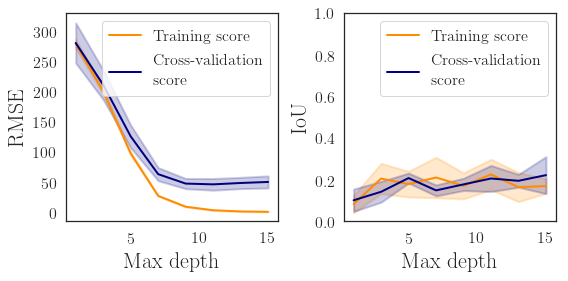

In [12]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121)

ax.set_xlabel(r"Max depth", fontsize=font_size)
ax.set_ylabel("RMSE", fontsize=font_size)
lw = 2
ax.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
ax.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
ax.plot(param_range, test_scores_mean, label="Cross-validation\nscore",
             color="navy", lw=lw)
ax.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
ax.legend(loc="best", frameon=True, prop={'size':16})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1 = fig.add_subplot(122)

ax1.set_xlabel(r"Max depth", fontsize=font_size)
ax1.set_ylabel("IoU", fontsize=font_size)
lw = 2
ax1.set_ylim(0,1)
ax1.plot(param_range, train_scores_mean_iou, label="Training score",
             color="darkorange", lw=lw)
ax1.fill_between(param_range, train_scores_mean_iou - train_scores_std_iou,
                 train_scores_mean_iou + train_scores_std_iou, alpha=0.2,
                 color="darkorange", lw=lw)
ax1.plot(param_range, test_scores_mean_iou, label="Cross-validation\nscore",
             color="navy", lw=lw)
ax1.fill_between(param_range, test_scores_mean_iou - test_scores_std_iou,
                 test_scores_mean_iou + test_scores_std_iou, alpha=0.2,
                 color="navy", lw=lw)
ax1.legend(loc="best", frameon=True, prop={'size':16})
plt.tight_layout()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('output/sensitivity/ml_models/max-depth-vs-iou-rmse.pdf',format='pdf',dpi=300)

In [11]:
plt.style.use('seaborn-ticks')
plt.rc('text', usetex=True)
font_size=22
params = {'backend': 'ps',
          'text.latex.preamble': ['\\usepackage{gensymb}'],
          'text.usetex': True,
          'font.family': 'serif'
}

plt.rcParams.update(params)

DEBUG:matplotlib.texmanager:serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '')
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: sans-serif, info: ('cmss', '')
DEBUG:matplotlib.texmanager:cursive font is not compatible with usetex.
DEBUG:matplotlib.texmanager:cursive font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
DEBUG:matplotlib.texmanager:monospace font is not compatible with usetex.
DEBUG:matplotlib.texmanager:monospace font is not compatible 

DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/cfb6a7240556f21c5ea876553ef6e041.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.texmanager:serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: serif, font: Computer Modern Roman, info: ('cmr', '')
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:sans-serif font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: sans-serif, info: ('cmss', '')
DEBUG:matplotlib.texmanager:cursive font is not compatible with usetex.
DEBUG:matplotlib.texmanager:cursive font is not compatible with usete

/home/fotis/anaconda3/envs/data_vis/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/042257ce4a74e485541fc2e9ce3f9f44.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/46c7005b58e200ca74f0f3f0ef0e1188.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/26c77c632c7d6d2589580ab48fa58bec.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/bbb49bebde07602af90e6c653719cb11.dvi
DEBUG:matplotlib.dvi

DEBUG:matplotlib.backends.backend_pdf:Embedding Type-1 font b'cmr12' from dvi.
DEBUG:matplotlib.backends.backend_pdf:Embedding TeX font b'cmr12' - fontinfo={'encodingfile': None, 'dvifont': <matplotlib.dviread.DviFont object at 0x7f4508d16308>, 'pdfname': <Name b'F1'>, 'basefont': b'CMR12', 'fontfile': '/usr/share/texlive/texmf-dist/fonts/type1/public/amsfonts/cm/cmr12.pfb', 'effects': {}}
DEBUG:matplotlib.backends.backend_pdf:Embedding Type-1 font b'cmr17' from dvi.
DEBUG:matplotlib.backends.backend_pdf:Embedding TeX font b'cmr17' - fontinfo={'encodingfile': None, 'dvifont': <matplotlib.dviread.DviFont object at 0x7f4508d16518>, 'pdfname': <Name b'F2'>, 'basefont': b'CMR17', 'fontfile': '/usr/share/texlive/texmf-dist/fonts/type1/public/amsfonts/cm/cmr17.pfb', 'effects': {}}
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/e5eb670

DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/e5eb6705878ce1f01325c742c7df4ae2.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/042257ce4a74e485541fc2e9ce3f9f44.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/46c7005b58e200ca74f0f3f0ef0e1188.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: 

DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/e5eb6705878ce1f01325c742c7df4ae2.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/042257ce4a74e485541fc2e9ce3f9f44.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home/fotis/.cache/matplotlib/tex.cache/46c7005b58e200ca74f0f3f0ef0e1188.dvi
DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
DEBUG:matplotlib.texmanager:fontconfig: serifcmrcmsspzccmtt20497a30a03f610e773b50fa581d240e
DEBUG:matplotlib.dviread:Dvi: /home

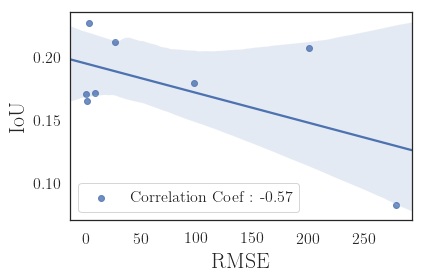

In [13]:
sns.regplot(train_scores_mean, train_scores_mean_iou, n_boot=1200, label='Correlation Coef : {0}'.format(np.round(np.corrcoef(train_scores_mean,train_scores_mean_iou)[0,1],2)))
plt.legend(loc='best', prop={'size': 16}, frameon=True)
plt.xlabel('RMSE', fontsize=22)
plt.ylabel('IoU', fontsize=22)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig('output/sensitivity/ml_models/rmse-corr-iou.pdf',format='pdf',dpi=300)

<h3>Sensitivity Analysis on GlowWorm parameters</h3>

In [ ]:
with open('models/queries-uniform-1-multi_False-aggr-XGB-RMSE=0.26-R2=0.97.pkl', 'rb') as file:  
    m = pickle.load(file)

In [ ]:
m.best_params_

In [ ]:
def objective_density(X):
    res = np.log(m.predict(X) - 1000) - c*np.sum(np.log(1+X[:,X.shape[1]//2:]),axis=1)
    res[np.isnan(res)] = -np.inf
    return res
def naive_objective_density(X):
    res = (m.predict(X) - 500) / np.sum(np.log(1+X[:,X.shape[1]//2:]),axis=1)**5
    return res
def objective_aggr(X):
    res = np.log(m.predict(X) - 2) - c*np.sum(np.log(1+X[:,X.shape[1]//2:X.shape[1]]),axis=1)
    res[np.isnan(res)] = -np.inf
    return res

In [ ]:
np.random.seed(0)

In [ ]:
iterations = [100,300, 500, 800, 1000, 1100]
glowworms = [50, 100, 150, 200]
cs = [1,2,3,4, 5, 6, 7, 8]
nts = [2, 3, 5, 10, 15]
r0s = np.linspace(0,1,6)
def run_opt(iters, glow, c_, nt, r0):
    global c
    c = c_
    logger.debug("Config iters={0}\tglowworms={1}\tc={2}".format(iters,glow,c))
    gw = GlowWorm(objective_density, dimensions=2,glowworms=glow,iter_max=iters,nt=nt,r0=r0)
    gw.optimize()
    proposed = gw.X[np.argsort(-objective_density(gw.X)),:][:10]
    boxes = compute_boxes(False, 1)
    iou = compute_iou(boxes, proposed,False, 1)
    return iou,proposed,gw.X

<h4>Keeping others constant</h4>

In [ ]:
iou_runs = []
for r in range(10):
    iou_iters = []
    for it in iterations:
        iou,p,x = run_opt(it, 50, 4, 5, 0.2)
        iou_iters.append(iou)
    iou_runs.append(iou_iters)
    
means = np.mean(iou_runs,axis=0)
stds = np.std(iou_runs,axis=0)

plt.fill_between(iterations, means - stds,
                 means + stds, alpha=0.1, color="g")
plt.plot(iterations, means, 'o-', color="r",)
plt.ylim(0,1)

In [ ]:
nts_runs = []
for r in range(10):
    nts_iters = []
    for nt in nts:
        iou,p,x = run_opt(100, 50, 4, nt, 0.2)
        nts_iters.append(iou)
    nts_runs.append(nts_iters)
means = np.mean(nts_runs,axis=0)
stds = np.std(nts_runs,axis=0)

plt.fill_between(nts, means - stds,
                 means + stds, alpha=0.1, color="g")
plt.plot(nts, means, 'o-', color="r",)
plt.ylim(0,1)

In [ ]:
cs_runs = []
for r in range(10):
    cs_iters = []
    for c in cs:
        iou,p,x = run_opt(100, 50, c, 5, 0.2)
        cs_iters.append(iou)
    cs_runs.append(cs_iters)
means = np.mean(cs_runs,axis=0)
stds = np.std(cs_runs,axis=0)

plt.fill_between(cs, means - stds,
                 means + stds, alpha=0.1, color="g")
plt.plot(cs, means, 'o-', color="r",)
plt.ylim(0,1)

In [ ]:
glow_runs = []
for r in range(10):
    glow_iters = []
    for g in glowworms:
        iou,p,x = run_opt(100, g, 4, 5, 0.2)
        glow_iters.append(iou)
    glow_runs.append(glow_iters)
means = np.mean(glow_runs,axis=0)
stds = np.std(glow_runs,axis=0)

plt.fill_between(glowworms, means - stds,
                 means + stds, alpha=0.1, color="g")
plt.plot(glowworms, means, 'o-', color="r",)
plt.ylim(0,1)

In [ ]:
r0s_runs = []
for r in range(10):
    r0s_iters = []
    for r0 in r0s:
        iou,p,x = run_opt(100, 50, 4, 5, r0)
        r0s_iters.append(iou)
    r0s_runs.append(r0s_iters)
means = np.mean(r0s_runs,axis=0)
stds = np.std(r0s_runs,axis=0)

plt.fill_between(r0s, means - stds,
                 means + stds, alpha=0.1, color="g")
plt.plot(r0s, means, 'o-', color="r",)
plt.ylim(0,1)

<h3>Optimization</h3>

In [ ]:
ious = []
configs = []
for it, glo, co,nt,r0 in itertools.product(*[iterations,glowworms, cs,nts, r0s]):
    iou = run_opt(it, glo,co,nt,r0)
    ious.append(iou)
    configs.append((it,glo,co,nt,r0))

In [ ]:
configs[np.argmax(ious)]

<h3>Convergence Rate</h3>

In [ ]:
with open('models/queries-uniform-1-multi_False-density-XGB-RMSE=51.92-R2=0.99.pkl', 'rb') as file:  
    m = pickle.load(file)

In [ ]:
global c
c = 4 

In [ ]:
gw = GlowWorm(objective_density,dimensions=2,log_trace=True,iter_max=100, r0=0.17)
gw.optimize()

In [ ]:
js = []
for i in range(0,gw.history.shape[1]-1,2):
    x_at_i = gw.history[:,i:i+2]
    j_vals = objective_density(x_at_i)
    j_vals = j_vals[j_vals!=-np.inf]
    js.append(np.mean(j_vals))
    

In [ ]:
plt.plot(range(101), js)
plt.ylabel('Expected J')
plt.xlabel('Iterations')

In [ ]:
convergence_rate = []
#Load models and run experiments
directory = os.fsencode('models')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if (not filename.startswith('queries')) or ('XGB' not in filename) or ('density' not in filename):
        continue;
    logger.debug(filename)
    a = filename.split('-')
    dims = int(a[2])
    multi = a[3].split('_')[1]=="True"
    aggr = a[4]
    m = None

    with open('models/%s' % filename, 'rb') as file:  
        m = pickle.load(file)
    def objective_density(X):
        res = np.log(m.predict(X) - 1000) - c*np.sum(np.log(1+X[:,X.shape[1]//2:]),axis=1)
        res[np.isnan(res)] = -np.inf
        return res
    glowworms = int(50*(2*dims))
    radius = (1-0.5**(1/50))**(1/(2*dims))
    gw = GlowWorm(objective_density,dimensions=2*dims,log_trace=True,iter_max=250,glowworms=glowworms, r0=radius)
    gw.optimize()
    js = []
    for i in range(0,gw.history.shape[1]-(2*dims),2*dims):
        x_at_i = gw.history[:,i:i+2*dims]
        j_vals = objective_density(x_at_i)
        j_vals = j_vals[j_vals!=-np.inf]
        js.append(np.mean(j_vals))

    convergence_rate.append([dims,multi,js, glowworms, radius])

In [ ]:
convergence_rate_df = pd.DataFrame(convergence_rate, columns=['Dimensions', 'Regions','Js','Glowworms','Radius'])

In [ ]:
convergence_rate_df['Js_n']= convergence_rate_df['Js'].apply(np.array)

In [ ]:
convergence_rate_df.to_csv('output/convergence_rate.csv')

In [ ]:
convergence_rate_df['Js_n'][2].shape

In [ ]:
convergence_rate_df

In [ ]:
fig,axes = plt.subplots(ncols=5, nrows=2,sharex=True ,figsize=(12,5), )
reg = [True, False]
dimensions = [1,2,3,4,5]
for i in range(2):
    for j in range(5):
        d = convergence_rate_df[(convergence_rate_df['Regions']==reg[i]) & (convergence_rate_df['Dimensions']==dimensions[j])]
        axes[i][j].plot(range(250),d['Js_n'].values[0])
        axes[i][j].set_title("k={0}\nDimensions={1}".format(3 if reg[i] else 1, (j+1)*2), fontsize=18)
        axes[i][j].grid(color='k', linestyle='dashed', linewidth=1, alpha=0.3)
        axes[i][j].tick_params(axis='y',labelsize=14)
        if i==1:
            axes[i][j].set_xlabel("Iterations", fontsize=22)
            axes[i][j].tick_params(axis='x',labelsize=18)
            
axes[0][0].set_ylabel(r'E$[\mathcal{J}]$', fontsize=22 )
axes[1][0].set_ylabel(r'E$[\mathcal{J}]$', fontsize=22)
plt.tight_layout()
plt.savefig('output/sensitivity/glowworms-convergence.pdf',format='pdf', dpi=300)

In [ ]:
def return_convergence_point(X):
    L = np.max(X)
    p_point = np.argmax((X[1:]-X[:-1]<0.05) & (np.abs(X[1:]-L)<=0.05))
    return p_point

In [ ]:
#average number of iterations needed to reach convergence
convergence_rate_df['Js_n'].apply(lambda x : return_convergence_point(x)).mean()

In [ ]:
plt.plot(convergence_rate_df['Js_n'][0])
plt.plot(p_point, convergence_rate_df['Js_n'][0][p_point], 'xr')

In [ ]:
#Rate of convergence sublinearly
L = np.max(convergence_rate_df['Js_n'][0])+1
plt.plot(np.abs(convergence_rate_df['Js_n'][0][1:]-L)/ np.abs(convergence_rate_df['Js_n'][0][:-1]-L))